# Module 2:  Feature Engineering


<a href="https://drive.google.com/file/d/1EZ_xqMaYj77vErVnrQmnFOj-VBEoO5uW/view?usp=sharing" target="_blank">
     <img src="http://www.deltanalytics.org/uploads/2/6/1/4/26140521/screen-shot-2019-01-05-at-4-48-29-pm_orig.png" width="500" height="400">
</a>

Feature Engineering is the process of transforming raw data into features/input variables that are easily digested by algorithms. People think that data scientists often spend most of their time testing out various algorithms; however, the majority of performance gains generally come from well-crafted features. 

While performing feature engineering, it is critical to keep in mind the question that you are trying to answer.  For the purposes of this exercise, we will be using the KIVA dataset and will be trying to answering the following question:

__What drives the loan amount requested by KIVA borrowers?__

Our outcome feature is __loan_amount__. In the next notebook, we will formalize this research question as a machine learning task. Our machine learning task will be to predict the loan amount that a borrower requests from KIVA using all the features we explore in this notebook.

We may not end up using all the features we create, but the process is an important extension of exploratory analysis. The key difference between feature engineering and exploratory analysis is that we now have a defined question in mind: "What drives the loan amount requested by KIVA lenders?"

In this lab, we will introduce the following types of feature engineering:

1. Feature pruning
1. Time-based features (month, year, etc)
1. One-hot encoding to create dummy variables
1. Extracting features from strings
1. Feature scaling
1. Data imputation / cleaning

In [0]:
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (15, 8)
sns.set()
sns.set(font_scale=1.5)

# Display up to 80 columns to keeps everything visible
pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)

%matplotlib inline

In [0]:
# Load data
path = ''
filename = '/loans.csv'
df = pd.read_csv(path+filename)

In [0]:
df.dtypes

id_number                 int64
loan_amount               int64
lender_count              int64
status                   object
funded_date              object
funded_amount             int64
repayment_term            int64
location_country_code    object
sector                   object
description              object
use                      object
dtype: object

In [0]:
df.head()

,id_number,loan_amount,lender_count,status,funded_date,funded_amount,repayment_term,location_country_code,sector,description,use,test feature
0,736066,4825,60,funded,2014-08-03 17:51:50+00:00,4825,8,BJ,Retail,NaN,NaN,1
1,743090,975,34,funded,2014-08-18 09:10:54+00:00,975,12,BJ,Food,NaN,NaN,1
2,743120,950,25,funded,2014-08-09 17:46:35+00:00,950,14,BJ,Services,NaN,NaN,1
3,743121,825,28,funded,2014-08-24 17:00:38+00:00,825,14,BJ,Retail,NaN,NaN,1
4,743124,725,21,funded,2014-08-25 03:24:54+00:00,725,13,BJ,Retail,NaN,NaN,1


## 1. Feature Pruning
No need to keep features that have zero variation.  Algorithms can only provide meaningful insights when there is variation in the features.  Given that we are performing feature engineering for the purpose of feeding these features into a machine learning algorithm, let's go ahead and remove all columns that only consist 1 or less unique values.

In [0]:
for col in df.columns:
    if df[col].unique().size==1:
        print("Dropping column: {0}".format(col))
        df = df.drop(col, axis=1)

## 2. Temporal Features
Time trends are very significant and should not be neglected.  Most algorithms will not be able to make use of raw datetimes; however, they will be able to find patterns in the data if they are informed which observations occur in a given year, on a weekday vs weekend, on a holiday, etc.

Before we are able to extract this metadata, let's convert the strings in the pandas dataframe to datetime objects. Luckily for us, all time fields in this dataset have "_date" in their name.

Pandas is really adept at time series analysis, and we will use pd.to_datetime to create pandas timestamps.
See a list of methods that can be applied to a pandas datetime here: https://pandas.pydata.org/pandas-docs/version/0.21/api.html#id34

In [0]:
for col in [c for c in df.columns if "_date" in c]:
    if "_date" in col:
        df[col] = pd.to_datetime(df[col])

In [0]:
df.dtypes

id_number                              int64
loan_amount                            int64
lender_count                           int64
status                                object
funded_date              datetime64[ns, UTC]
funded_amount                          int64
repayment_term                         int64
location_country_code                 object
sector                                object
description                           object
use                                   object
dtype: object

### .dt accessor
The pandas .dt accessor enables you to easily construct additional features based off of these datetimes.

In [0]:
# This is temporally commented out if we really want to date based analysis

# ##  posted date features
# df['posted_year']=df['posted_date'].dt.year
# df['posted_month']=df['posted_date'].dt.month

# ## Time to fund is the funded date minus the posted date
# ## we add these fields because the homework question in the next notebook involves predicting time to fund
# df['time_to_fund'] =df['funded_date'] - df['posted_date']
# df['days_to_fund'] = df['time_to_fund'].dt.days

# # expiration date features
# ## Time to expiration is the expiration date minus the Posted Date
# df['time_to_expire_date'] =df['planned_expiration_date'] - df['posted_date']
# df['days_to_expire'] = df['time_to_expire_date'].dt.days

In [0]:
df['test feature'] = 1

## 3. One-hot encoding
One-hot encoding is the process of converting either categorical or string data into a binary. Let's practice one-hot encoding by converting the "tags" column into a set of binary features indicating whether or not a particular tag appears in a given row. 

In order to do this we will first need to convert the "tags" column into a list of strings. Then, we will utilize the pandas `get_dummies` method to create the binary features.  Binary features are often referred as dummy features in the statistics world.



In [0]:
pd.get_dummies(df.sector).head(n=2)

,Agriculture,Arts,Clothing,Construction,Education,Food,Health,Housing,Manufacturing,Personal Use,Retail,Services,Transportation,Wholesale
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [0]:
df.sector.unique()

array(['Retail', 'Food', 'Services', 'Clothing', 'Arts', 'Agriculture',
       'Manufacturing', 'Construction', 'Wholesale', 'Health',
       'Transportation', 'Education', 'Housing', 'Personal Use'],
      dtype=object)

## 4. Extracting features from strings

String variables by themselves are generally not good inputs to algorithms; however, it is often possible to extract meaningful features from encoding the information that they contain.  Let's first find out which of our variables are string variables.  From there, let's review some of the variables and see if we can construct new features from the contents of these string variables.

To discover which of our dataframe columns are string variables, we will utilize the pandas `dtypes` method, short for 'data type'.  In pandas, there are the following types:

|       dtype        |        Description        |
|:--------------------|:---------------------------|
|      float         | Numeric value with a decimal point.  If NaNs exist in col, pandas will default to float|
|        int         | Numerica values without decimal points. |
|       bool         | Column consisting of True and False|
| datetime64[ns, tz] | Objects which contain specific date and time |
|   timedelta[ns]    | Object which indicates time elapsed between two datetimes |
|     category       | Variables that can only have specified values |
|      object        | Pandas representation of string variables |

Let's now use pandas method `get_dtype_counts` to see what data types exist in the dataframe, and then apply `select_dtypes` to view all columns with `dtype == object`.

In [0]:
df.get_dtype_counts()

datetime64[ns, UTC]    1
int64                  6
object                 5
dtype: int64

In [0]:
df.select_dtypes(include=[int])

,id_number,loan_amount,lender_count,funded_amount,repayment_term,test feature
0,736066,4825,60,4825,8,1
1,743090,975,34,975,12,1
2,743120,950,25,950,14,1
3,743121,825,28,825,14,1
4,743124,725,21,725,13,1
5,743125,725,27,725,13,1
6,743130,725,27,725,13,1
7,743134,525,14,525,13,1
8,743207,950,35,950,14,1
9,743228,500,10,500,10,1


Maybe the length of text description could help use

In [0]:
df['description_length']  = df.description.str.len()

In [0]:
df['description_length'].tail()

6014    660.0
6015    588.0
6016    614.0
6017    591.0
6018    592.0
Name: description_length, dtype: float64

## 5. Feature Scaling

We will not overwrite our dataframe with scaled values because the appropriate scaling technique depends on the algorithm.  These are the three most common feature scaling techniques:
1. Normalization
2. Standardization
3. Log-transformation

Normalization is the process of rescaling the data from 0-1.  The formula for this approach is:

`X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min` 

In [0]:
preprocessing.MinMaxScaler()
min_max_scaler = preprocessing.MinMaxScaler()
normalized = min_max_scaler.fit_transform(df['loan_amount'].astype(np.float64).values.reshape(-1,1))[:,0]
print("Pre Scaling\tMin: {0}\t\t Max: {1}\tMean: {2:3f}".format(df['loan_amount'].min(),df['loan_amount'].max(),df['loan_amount'].mean()))
print("Post Scaling\tMin: {0}\t Max: {1:.3f}\tMean: {2:3f}".format(np.min(normalized),np.max(normalized),np.mean(normalized)))

Pre Scaling	Min: 50		 Max: 80000	Mean: 1499.011464
Post Scaling	Min: 0.0	 Max: 1.000	Mean: 0.018124


Standardization assumes normally distributed data (i.e., Gaussian) and scales the data so that it has a zero mean and unit variance.  Below is the formula:
$${\dfrac{x - \bar x}{\sigma}}$$

In [0]:
standardized = preprocessing.scale(df['loan_amount'].astype(np.float64))
print("Post Scaling\tMin: {0:3f}\t Max: {1:3f}\tMean: {2:3f}".format(np.min(standardized),np.max(standardized),np.mean(standardized)))

Post Scaling	Min: -0.576765	 Max: 31.246555	Mean: -0.000000


From these values, it appears that our data has a skewed distribution and is actually a good candidate for a log transformation.

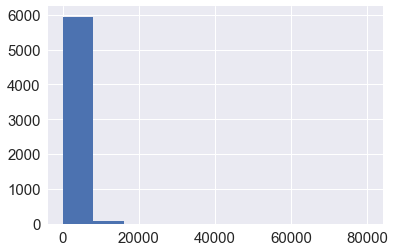

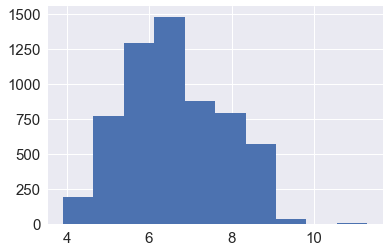

In [0]:
plt.hist(df['loan_amount'])
plt.show()
log_loan_amount = np.log(df['loan_amount'])
plt.hist(log_loan_amount)
plt.show()

## 7. Data Imputation / cleaning

Missing data can be informative, but it also will prevent many algorithms from training.  In order to enable our models to train while preserving the fact that some data is missing, we are going to:
1. Create a new column that indicates whether or not that column had missing data.
In pandas, missing data is either represented as NaN (Not a Number), or NaT (Not a Time).  While we look at our missing data, let's look at strings, numeric, and time objects separately.

2. Impute missing data with the column's mean.

First, let's have a quick refresher on data types in our dataframe and create lists of all of the columns for specific data types.

In [0]:
df.get_dtype_counts()

datetime64[ns, UTC]    1
int64                  6
object                 5
float64                1
dtype: int64

In [0]:
time_columns = df.select_dtypes(include=['datetime64','timedelta64']).columns
str_columns = df.select_dtypes(include=[object]).columns
numeric_columns = df.select_dtypes(exclude=[object,'datetime64','timedelta64']).columns

Now, let's use pandas `isnull` and `sum` functions to see how many observations of each column are missing.
Since there are a lot of columns in this dataframe, let's restrict our returned dataframe to columns which have 
missing data

In [0]:
df[time_columns].isnull().sum()[df[time_columns].isnull().sum()>0]

Series([], dtype: float64)

In [0]:
df[str_columns].isnull().sum()[df[str_columns].isnull().sum()>0]

location_country_code     17
description              342
use                      342
dtype: int64

In [0]:
df[numeric_columns].isnull().sum()[df[numeric_columns].isnull().sum()>0]

description_length    342
dtype: int64

With missing data, you should always check to see if there is a systemic difference between observations with and without missing data.

In [0]:
df[df['funded_date'].isnull()].describe()

,id_number,loan_amount,lender_count,funded_amount,repayment_term,description_length
count,9.370000e+02,937.000000,937.000000,937.000000,937.000000,937.000000
mean,1.553091e+06,1566.942369,13.839915,449.599787,12.324440,755.668090
std,6.970535e+04,1959.649153,24.887396,881.083386,4.269421,270.137706
min,1.035139e+06,100.000000,0.000000,0.000000,5.000000,209.000000
25%,1.563631e+06,425.000000,0.000000,0.000000,9.000000,572.000000
50%,1.568888e+06,725.000000,4.000000,100.000000,12.000000,711.000000
75%,1.571593e+06,1500.000000,14.000000,375.000000,14.000000,906.000000
max,1.573593e+06,10000.000000,196.000000,7450.000000,39.000000,1514.000000


In [0]:
df[~df['funded_date'].isnull()].describe()

,id_number,loan_amount,lender_count,funded_amount,repayment_term,description_length
count,5.082000e+03,5082.000000,5082.000000,5082.000000,5082.000000,4740.000000
mean,1.324127e+06,1486.486619,39.684770,1486.486619,11.707202,738.523418
std,3.934281e+05,2601.625321,78.527144,2601.625321,9.746101,269.246968
min,1.377200e+04,50.000000,1.000000,50.000000,3.000000,74.000000
25%,1.138890e+06,275.000000,8.000000,275.000000,8.000000,553.000000
50%,1.541855e+06,600.000000,19.000000,600.000000,10.000000,696.000000
75%,1.563550e+06,1850.000000,45.000000,1850.000000,14.000000,894.250000
max,1.573032e+06,80000.000000,2665.000000,80000.000000,133.000000,3107.000000


Create columns that indicate whether or not data is missing:

In [0]:
for col in numeric_columns:
    df[col+'_na'] = pd.isnull(df[col])

Impute missing data with the mean:

In [0]:
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

THE END!
-----

That is all for our feature engineering module!  

Now that we have finished creating all of our features, we can go ahead save our results into a new csv.

In [0]:
df.to_csv("/loans_additional_features.csv", index=False) 

<br>
<br> 
<br>

----